In [1]:
import numpy as np 
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import euclidean_distances
import SemisupFns as SF
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import MiscFcns as MF
import seaborn as sns
import scipy.stats as ss
import mygene
%matplotlib inline

In [2]:
#Reading feature vector 
X = pd.read_csv('./amp_ad_rna_DE_feature_set.csv')

#Dropping GeneID column 
GeneId = X['GeneID']
X = X.drop(['GeneID'], axis = 1)
X.head()
X = X.fillna(0)

#Reading response vector 
Y = pd.read_excel('./ResponseVec_040318.xlsx')
Y = Y.drop(['GeneID'], axis = 1)
Y.head()

,Y
0,0
1,0
2,0
3,0
4,0


In [3]:
#Performing dimensionality reduction using PCA to 2 dimensions 
pca = PCA(n_components=20)
X2 = X.abs()
X_normed = X.values / X2.values.max(axis=0)
pca.fit(X_normed)
X_pca = pca.fit_transform(X_normed)

In [4]:
X.shape

(14448, 377)

Text(0,0.5,u'PC 2')

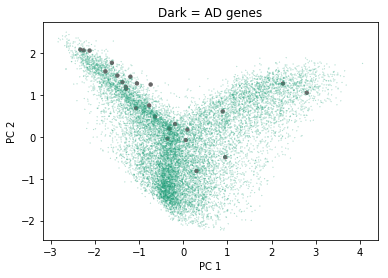

In [5]:
#Coloring the known AD related genes differently 
plt.scatter(X_pca[:,0],X_pca[:,1], c = Y.values[:,0] , 
            s =(Y.values[:,0] +.5)**6, cmap = 'Dark2')
plt.title('Dark = AD genes')
plt.xlabel('PC 1') 
plt.ylabel('PC 2')

In [6]:
#Balancing classes for better classification performance 
tmp = SF.BalanceClasses(X_normed + 0.0 ,Y.values + 0.0)
X_train, y_train = tmp['X'],tmp['y']

In [38]:
Cs = np.logspace(-4,4,20)
C_best = SF.GetBestModel(X_train,y_train,pen='l2',Cs = Cs)
print C_best

[10000.]


In [39]:
C_best = 1e4
D = SF.IterativeTraining(X_normed + 0.0, Y.values + 0.0 ,C = C_best,pen='l2',Iter = 10, 
                      Thresh = 0.9)

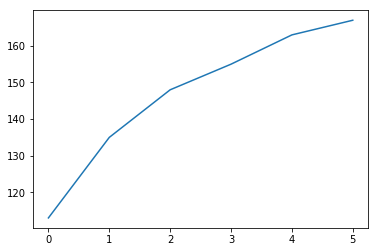

In [40]:
plt.plot(D['NoPos'])

In [41]:
def CrossValScore(Mdl,X,y):
    c, r = y.shape
    y = y.reshape(c,)
    Prec = cross_val_score(Mdl, X, y, cv=10, scoring='precision')
    Rec = cross_val_score(Mdl, X, y, cv=10, scoring='recall')
    AUC = cross_val_score(Mdl, X, y, cv=10, scoring='roc_auc')
    
    return {'Prec':Prec, 'Rec':Rec, 'AUC':AUC}

In [42]:
Scores = CrossValScore(D['LR'],X_train + 0.0,y_train + 0.0)

In [43]:
Y_pred = D['LR'].predict(X_normed)

In [44]:
Scores

{'AUC': array([0.99007852, 0.99653596, 0.99121191, 0.99309018, 0.99694926,
        0.99617143, 0.99419967, 0.99586893, 0.99761466, 0.99875154]),
 'Prec': array([0.94996708, 0.97565923, 0.97237197, 0.97171717, 0.98163265,
        0.9749831 , 0.98028552, 0.98162015, 0.99379738, 0.99311295]),
 'Rec': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [14]:
#fit regular logistic regression 
LR = LogisticRegression(penalty = 'l2', solver = 'saga', C = 1e4)
LR.fit(X_train,y_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [15]:
Scores2 = CrossValScore(LR,X_train + 0.0,y_train + 0.0)
Scores2

{'AUC': array([0.99007852, 0.99653596, 0.99121191, 0.99311805, 0.99689399,
        0.99617143, 0.9941434 , 0.9958141 , 0.99761466, 0.99875154]),
 'Prec': array([0.94996708, 0.97631935, 0.97237197, 0.97171717, 0.98163265,
        0.9749831 , 0.98095238, 0.98162015, 0.99379738, 0.99311295]),
 'Rec': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}

In [45]:
sum(D['LR'].predict(X_normed) == LR.predict(X_normed))

14321

In [46]:
Y1 = D['LR'].predict(X_normed)

Y2 = LR.predict(X_normed)

print(sum(Y1))
print(sum(Y2))

print(sum(Y1*Y2))

Y1 = D['LR'].predict_proba(X_normed)
Y1 = Y1[:,1]

print(sum(Y1*np.array(Y.values)[:,0])/sum(Y.values))


Y2 = LR.predict_proba(X_normed)
Y2 = Y2[:,1]

print(sum(Y2*np.array(Y.values)[:,0])/sum(Y.values))


275.0
246.0
197.0
[0.96666635]
[0.98035612]


In [18]:
sum(Y1_p)

NameError: name 'Y1_p' is not defined

In [47]:
np.array(Y.values)[:,0]

array([0, 0, 0, ..., 0, 0, 0])

Text(0.5,1,u'Non-Iterative')

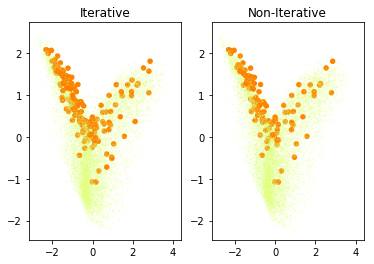

In [48]:
#Coloring PCs based on predicted probabilities sized by known AD genes (for iterative model)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.scatter(X_pca[:,0],X_pca[:,1], c = Y1 , s =(20*(Y1>0.9)+.01), cmap = 'Wistia')
ax1.set_title('Iterative')

ax2.scatter(X_pca[:,0],X_pca[:,1], c = Y2 , s =(20*(Y2>0.9)+.01), cmap = 'Wistia')
ax2.set_title('Non-Iterative')


Text(0.5,1,u'Non-Iterative')

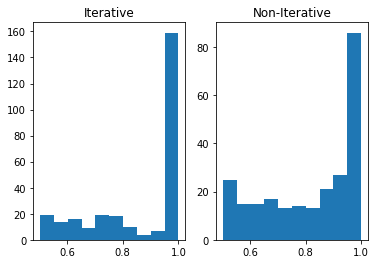

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)

ax1.hist(Y1[Y1>0.5])
ax1.set_title('Iterative')
ax2.hist(Y2[Y2>0.5])
ax2.set_title('Non-Iterative')

In [50]:
#Getting list of genes which have SNPs according to IGAP_stage1
cnt = 0 
GeneNames = []
MinPval = []
AvgLogPval = []
with open("/Users/sumitmukherjee/Documents/AMP-AD_Network_Analysis/IGAP_files/IGAP_geneAnalysis.genes.raw") as f:
    for line in f:
        if cnt <= 1:
            cnt+=1 
            continue
            
        cnt += 1
        temp = line.split(' ')

        if len(temp)>9:
            GeneNames += [temp[0]]
            temp = map(float,temp[9:])
            MinPval += [min(temp)]
            AvgLogPval += [np.mean(np.log10(temp))]
        

In [51]:
#Getting the ENSEMBL ID's of the predicted regulator genes
bla = np.argwhere(Y1>0.5)
GenePred = list(GeneId[bla[:,0]])
GenePredVal = list(Y1[bla[:,0]])
#Converting to Gene Symbols 
GenePred2 = MF.ConvertToSymb(GenePred)

querying 1-275...done.
Finished.
3 input query terms found dup hits:
	[(u'ENSG00000160209', 2), (u'ENSG00000105650', 2), (u'ENSG00000076928', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [52]:
IGAP_genes = pd.DataFrame(data = {'Genes':GeneNames,'Pval':MinPval,'MeanPval':AvgLogPval})
IGAP_genes.head()

,Genes,MeanPval,Pval
0,ISG15,-0.148666,0.710123
1,AGRN,-0.142638,0.679699
2,RNF223,-0.381026,0.340268
3,C1orf159,-0.833337,0.091718
4,TTLL10,-2.191774,0.003411


In [53]:
def PredGenesPval(IGAP_genes,GenePred, GenePredVal):
    Int = list(set(GeneNames).intersection(GenePred))
    GenePred = pd.DataFrame({'G':GenePred})
    
    G = [] 
    P = []
    Pmean = []
    Y = []
    
    for i in range(len(Int)):
        In = IGAP_genes['Genes'][IGAP_genes['Genes']==Int[i]].index[0]
        In2 = GenePred['G'][GenePred['G']==Int[i]].index[0]
        G += [IGAP_genes['Genes'][In]]
        P += [IGAP_genes['Pval'][In]]
        Pmean += [IGAP_genes['MeanPval'][In]]
        Y += [GenePredVal[In2]]
        
        
    OR = np.log10(np.array(Y)/(1-np.array(Y)))
    PredGenes_pval = pd.DataFrame(data = {'GeneSymb':G,'Pval':P,'MeanPval':Pmean,'Y':Y,'OR':OR})
    return PredGenes_pval
    

In [54]:
#Getting p-values of predicted genes 
PredGenes_pval = PredGenesPval(IGAP_genes,GenePred2, GenePredVal)
PredGenes_pval.head()

PredGenes_pval.to_csv('PredictedGenesDE_L2_Iter_0508.csv')

[[1.         0.02870056]
 [0.02870056 1.        ]]


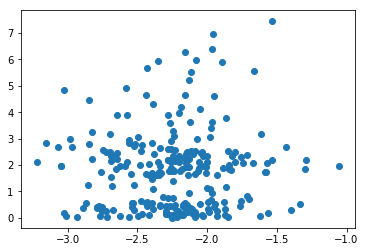

In [55]:
x = PredGenes_pval['MeanPval']
y = PredGenes_pval['OR']
plt.scatter(x,y)
print np.corrcoef(x,y)

Text(0.5,1,u'Predicted')

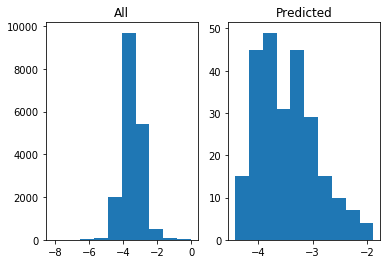

In [56]:
#Comparing min p-values of all genes on IGAP stage 1 with those from our prediction 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.hist(np.log10(IGAP_genes['Pval']))
ax1.set_title('All')
ax2.hist(np.log10(PredGenes_pval['Pval']))
ax2.set_title('Predicted')

Text(0.5,1,u'Predicted')

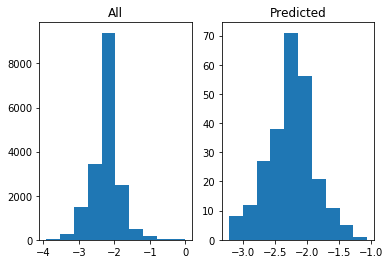

In [57]:
#Comparing average p-values of all genes on IGAP stage 1 with those from our prediction 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.hist((IGAP_genes['MeanPval']))
ax1.set_title('All')
ax2.hist((PredGenes_pval['MeanPval']))
ax2.set_title('Predicted')

In [58]:
#Get t-test value (min)
temp = ss.ttest_ind(np.log10(IGAP_genes['Pval']),np.log10(PredGenes_pval['Pval']))
print temp

Ttest_indResult(statistic=-0.09402255056129291, pvalue=0.9250922862940385)


In [59]:
#Get t-test value (mean)
temp = ss.ttest_ind((IGAP_genes['MeanPval']),(PredGenes_pval['MeanPval']))
print temp

Ttest_indResult(statistic=0.800162983045094, pvalue=0.42362689801227926)


## Vanilla logistic regression 

In [161]:
#For vanilla logistic regression
bla = np.argwhere(Y2>0.5)
GenePred = list(GeneId[bla[:,0]])
GenePredVal = list(Y1[bla[:,0]])
#Converting to Gene Symbols 
GenePred2 = MF.ConvertToSymb(GenePred)

querying 1-297...done.
Finished.
1 input query terms found dup hits:
	[(u'ENSG00000159216', 2)]
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [162]:
#Getting p-values of predicted genes 
PredGenes_pval = PredGenesPval(IGAP_genes,GenePred2, GenePredVal)
PredGenes_pval.head()

PredGenes_pval.to_csv('PredictedGenes_L2_Vanilla_0430.csv')

[[1.         0.04795048]
 [0.04795048 1.        ]]


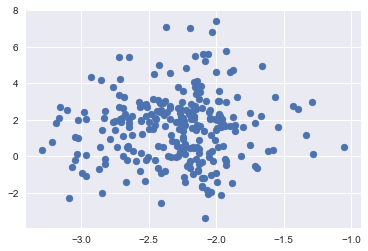

In [163]:
x = PredGenes_pval['MeanPval']
y = PredGenes_pval['OR']
plt.scatter(x,y)
print np.corrcoef(x,y)

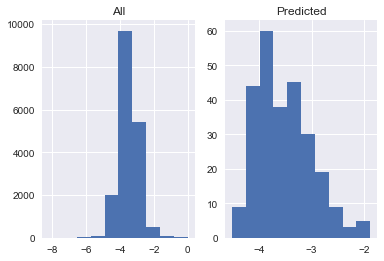

In [164]:
#Comparing min p-values of all genes on IGAP stage 1 with those from our prediction 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.hist(np.log10(IGAP_genes['Pval']))
ax1.set_title('All')
ax2.hist(np.log10(PredGenes_pval['Pval']))
ax2.set_title('Predicted')

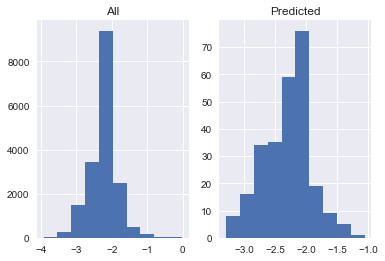

In [165]:
#Comparing average p-values of all genes on IGAP stage 1 with those from our prediction 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.hist((IGAP_genes['MeanPval']))
ax1.set_title('All')
ax2.hist((PredGenes_pval['MeanPval']))
ax2.set_title('Predicted')

In [166]:
#Get t-test value (min)
temp = ss.ttest_ind(np.log10(IGAP_genes['Pval']),np.log10(PredGenes_pval['Pval']))
print temp

Ttest_indResult(statistic=1.6606798332863926, pvalue=0.09679511230825914)


In [167]:
#Get t-test value (mean)
temp = ss.ttest_ind((IGAP_genes['MeanPval']),(PredGenes_pval['MeanPval']))
print temp

Ttest_indResult(statistic=2.9137387775971058, pvalue=0.003575662718112816)


## Shortlisting genes to look at 

In [188]:
IterList = pd.read_csv('./PredictedGenes_L2_Iter_0430.csv')
IterList.head()

,Unnamed: 0,GeneSymb,MeanPval,OR,Pval,Y,Score (OR*MV)
0,278,CRIM1,-2.790007,7.001227,0.000101,1.000000,19.533474
1,64,FAT4,-2.851320,5.592087,0.000091,0.999997,15.944829
2,133,EIF4EBP1,-2.063445,7.050294,0.000350,1.000000,14.547897
3,65,NETO1,-2.827766,4.814190,0.000172,0.999985,13.613402
4,245,LRP11,-1.819154,7.422455,0.000170,1.000000,13.502587


In [189]:
#List of known AD genes 

AD_genes = ['CELF1', 'PSEN2', 'SPI1', 'HLA-DRB1', 'PLCG2', 'PSEN1', 'HLA-DRB5', 
            'ABCA7', 'ABI3', 'FERMT2', 'SORL1', 'APOE', 'PICALM', 'INPP5D', 'CLU', 
            'CD2AP', 'MEF2C', 'TREM2, PTK2B', 'BIN1', 'APP', 'ABI3', 'PLCG2', 'SPI1', 
            'ADAM10', 'ADAMTS4', 'ACE', 'RIN3', 'AREL1', 'SLC4A9']

In [190]:
#Creating new score 
Score = IterList['MeanPval']*IterList['OR']
IterList['Score'] = Score
IterList = IterList.sort_values(by = 'Score')
IterList.head()

,Unnamed: 0,GeneSymb,MeanPval,OR,Pval,Y,Score (OR*MV),Score
0,278,CRIM1,-2.790007,7.001227,0.000101,1.000000,19.533474,-19.533474
1,64,FAT4,-2.851320,5.592087,0.000091,0.999997,15.944829,-15.944829
2,133,EIF4EBP1,-2.063445,7.050294,0.000350,1.000000,14.547897,-14.547897
3,65,NETO1,-2.827766,4.814190,0.000172,0.999985,13.613402,-13.613402
4,245,LRP11,-1.819154,7.422455,0.000170,1.000000,13.502587,-13.502587


In [221]:
#Getting ranking of known genes given a category

def RankedListGene(IterList,Cat):
    
    IterList.sort_values(by = Cat)
    GeneRank = []

    for i in range(len(AD_genes)):
        In = IterList['GeneSymb'][IterList['GeneSymb'] == AD_genes[i]]
        if len(In) != 0:
            GeneRank += [In.index[0]]
    
    return GeneRank        
    

(array([5., 2., 1., 1., 3., 2., 5., 2., 0., 4.]),
 array([ 19. ,  43.6,  68.2,  92.8, 117.4, 142. , 166.6, 191.2, 215.8,
        240.4, 265. ]),
 <a list of 10 Patch objects>)

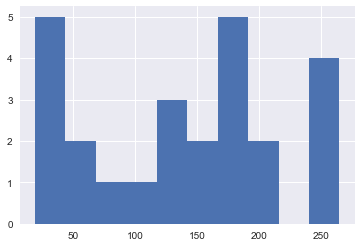

In [222]:
Temp = RankedListGene(IterList,'Score')
plt.hist(Temp)

In [223]:
#Creating new column indicating whether a gene has evidence 
IterList['Evidence'] = np.zeros(len(IterList['MeanPval']))
IterList['Evidence'][Temp] = 1

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [224]:
IterList.to_csv('PredictedGenes_L2_Iter_0430.csv')

In [247]:
Y1 = D['LR'].predict(X_normed)
Y_t = np.array(Y.values)
Y_t = Y_t.reshape(len(Y_t))
sum(Y1*Y_t)

25.0